<a href="https://colab.research.google.com/github/2303A52010/XAI/blob/main/XAI_2010_A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import shap
import lime
from lime import lime_tabular
from sklearn.inspection import partial_dependence

Dataset Shape: (1000, 10)

Data Types:
 age                            int64
gender                        object
pack_years                   float64
radon_exposure                object
asbestos_exposure             object
secondhand_smoke_exposure     object
copd_diagnosis                object
alcohol_consumption           object
family_history                object
lung_cancer                   object
dtype: object

Missing Values:
 age                            0
gender                         0
pack_years                     0
radon_exposure                 0
asbestos_exposure              0
secondhand_smoke_exposure      0
copd_diagnosis                 0
alcohol_consumption          334
family_history                 0
lung_cancer                    0
dtype: int64

Summary Statistics:
                age   pack_years
count  1000.000000  1000.000000
mean     56.994000    49.090413
std      23.605363    28.778144
min      18.000000     0.408278
25%      36.000000    23.905660
5

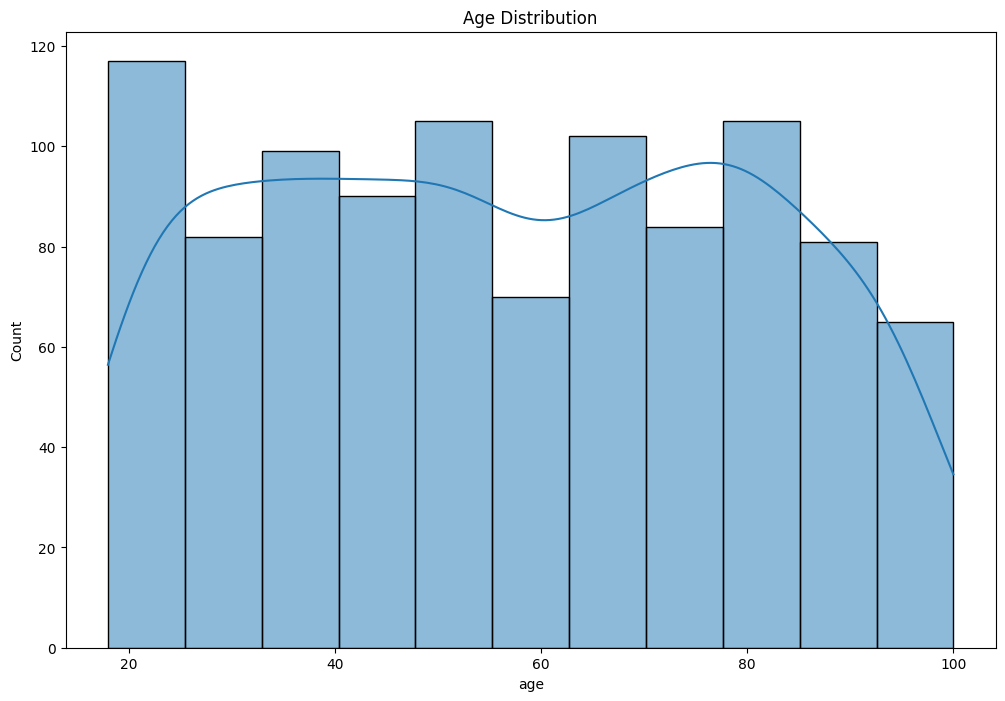

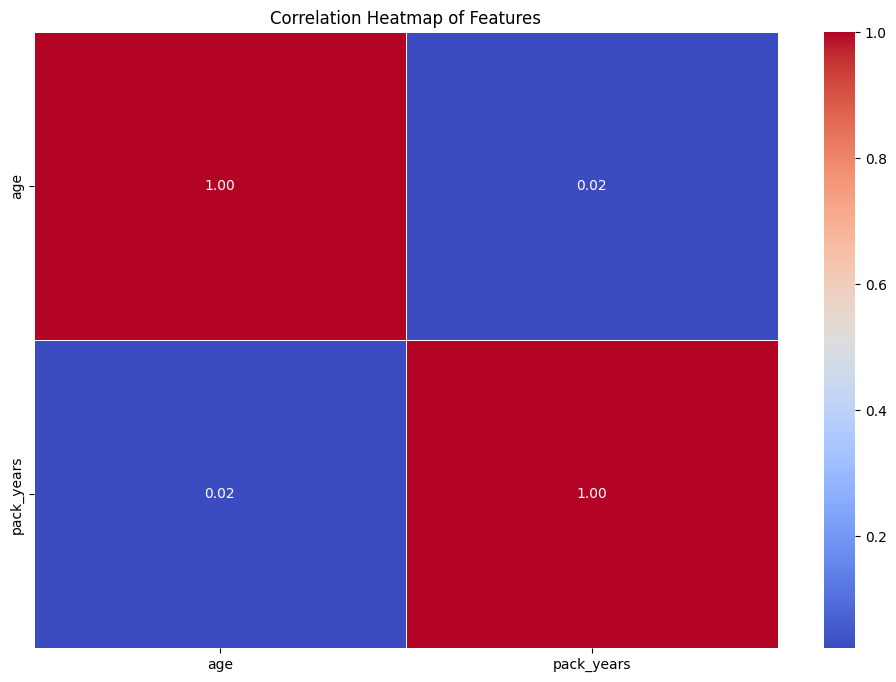

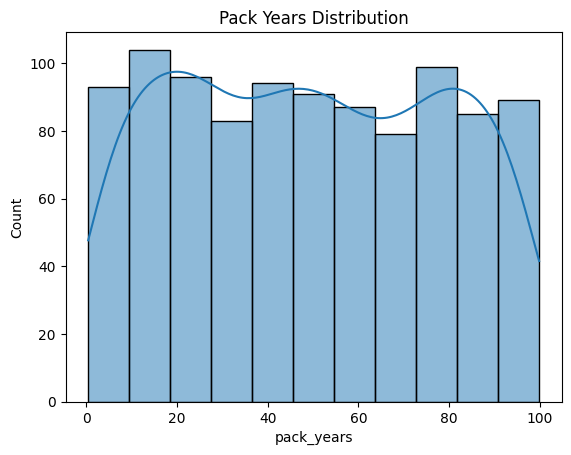

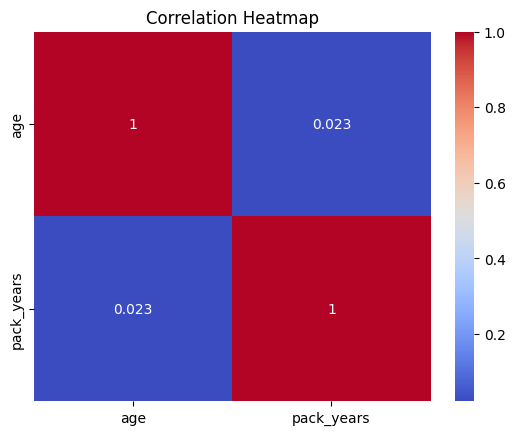

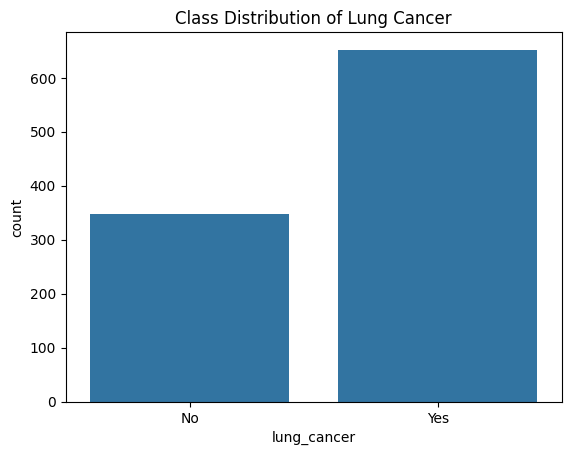


Class Counts:
 lung_cancer
Yes    652
No     348
Name: count, dtype: int64


In [38]:
# Load and limit dataset to 1,000 rows
df = pd.read_csv('lung_cancer_dataset.csv').head(1000)

# Drop patient_id as it's not useful
df.drop('patient_id', axis=1, inplace=True)

# Part 1: Exploratory Data Analysis (EDA)
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

print("\nSummary Statistics:\n", df.describe())

plt.figure(figsize=(12, 8))
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')
plt.show()

plt.figure(figsize=(12, 8))
corr = df.corr(numeric_only=True)   # computes correlation only on numeric columns
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()



sns.histplot(df['pack_years'], kde=True)
plt.title('Pack Years Distribution')
plt.show()

numerical_cols = ['age', 'pack_years']
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

sns.countplot(x='lung_cancer', data=df)
plt.title('Class Distribution of Lung Cancer')
plt.show()
print("\nClass Counts:\n", df['lung_cancer'].value_counts())

In [39]:
# Part 2: Preprocessing
imputer = SimpleImputer(strategy='most_frequent')
df['alcohol_consumption'] = imputer.fit_transform(df[['alcohol_consumption']]).ravel()

categorical_cols = ['gender', 'radon_exposure', 'asbestos_exposure', 'secondhand_smoke_exposure',
                    'copd_diagnosis', 'alcohol_consumption', 'family_history']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

df['lung_cancer'] = le.fit_transform(df['lung_cancer'])  # 'Yes' -> 1, 'No' -> 0

scaler = StandardScaler()
df[['age', 'pack_years']] = scaler.fit_transform(df[['age', 'pack_years']])

X = df.drop('lung_cancer', axis=1)
y = df['lung_cancer']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("\nAfter SMOTE - Train Class Counts:\n", pd.Series(y_train).value_counts())


After SMOTE - Train Class Counts:
 lung_cancer
1    519
0    519
Name: count, dtype: int64


In [40]:
# Part 3: Machine Learning Models
ml_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

ml_results = {}
for name, model in ml_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    ml_results[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'ROC-AUC': auc}

ml_results_df = pd.DataFrame(ml_results).T
print("\nML Models Performance:\n", ml_results_df)


ML Models Performance:
                      Accuracy  Precision    Recall        F1   ROC-AUC
Logistic Regression     0.670   0.772358  0.714286  0.742188  0.721805
Decision Tree           0.630   0.747899  0.669173  0.706349  0.610706
Random Forest           0.665   0.766129  0.714286  0.739300  0.745483
SVM                     0.665   0.794643  0.669173  0.726531  0.727640
KNN                     0.605   0.728814  0.646617  0.685259  0.656941
Gradient Boosting       0.720   0.818182  0.744361  0.779528  0.773763
XGBoost                 0.715   0.792308  0.774436  0.783270  0.732465


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:18:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [41]:
# Part 4: Deep Learning Models
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

def train_dl_model(model, epochs=10):
    optimizer = Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCELoss()
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

def evaluate_dl_model(model):
    model.eval()
    with torch.no_grad():
        pred = model(X_test_t)
        pred_bin = (pred > 0.5).float()
        acc = accuracy_score(y_test_t.numpy(), pred_bin.numpy())
        f1 = f1_score(y_test_t.numpy(), pred_bin.numpy())
        cm = confusion_matrix(y_test_t.numpy(), pred_bin.numpy())
    return acc, f1, cm

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

mlp = MLP(X.shape[1])
mlp = train_dl_model(mlp)
mlp_acc, mlp_f1, mlp_cm = evaluate_dl_model(mlp)
print("\nMLP - Accuracy:", mlp_acc, "F1:", mlp_f1)
print("Confusion Matrix:\n", mlp_cm)

class CNN1D(nn.Module):
    def __init__(self, input_size):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(64 * input_size, 64)
        self.fc2 = nn.Linear(64, 1)
    def forward(self, x):
        x = x.unsqueeze(1)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

cnn = CNN1D(X.shape[1])
cnn = train_dl_model(cnn)
cnn_acc, cnn_f1, cnn_cm = evaluate_dl_model(cnn)
print("\n1D CNN - Accuracy:", cnn_acc, "F1:", cnn_f1)
print("Confusion Matrix:\n", cnn_cm)

class LSTMNet(nn.Module):
    def __init__(self, input_size):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
    def forward(self, x):
        x = x.unsqueeze(1)
        _, (h, _) = self.lstm(x)
        x = nn.functional.relu(self.fc1(h.squeeze(0)))
        x = torch.sigmoid(self.fc2(x))
        return x

lstm = LSTMNet(X.shape[1])
lstm = train_dl_model(lstm)
lstm_acc, lstm_f1, lstm_cm = evaluate_dl_model(lstm)
print("\nLSTM - Accuracy:", lstm_acc, "F1:", lstm_f1)
print("Confusion Matrix:\n", lstm_cm)


MLP - Accuracy: 0.675 F1: 0.7368421052631579
Confusion Matrix:
 [[44 23]
 [42 91]]

1D CNN - Accuracy: 0.65 F1: 0.6875
Confusion Matrix:
 [[53 14]
 [56 77]]

LSTM - Accuracy: 0.675 F1: 0.752851711026616
Confusion Matrix:
 [[36 31]
 [34 99]]



Random Forest Feature Importances:
                      Feature  Importance
2                 pack_years    0.334393
0                        age    0.289381
3             radon_exposure    0.078899
4          asbestos_exposure    0.065014
6             copd_diagnosis    0.056859
5  secondhand_smoke_exposure    0.051374
8             family_history    0.047018
1                     gender    0.040985
7        alcohol_consumption    0.036076


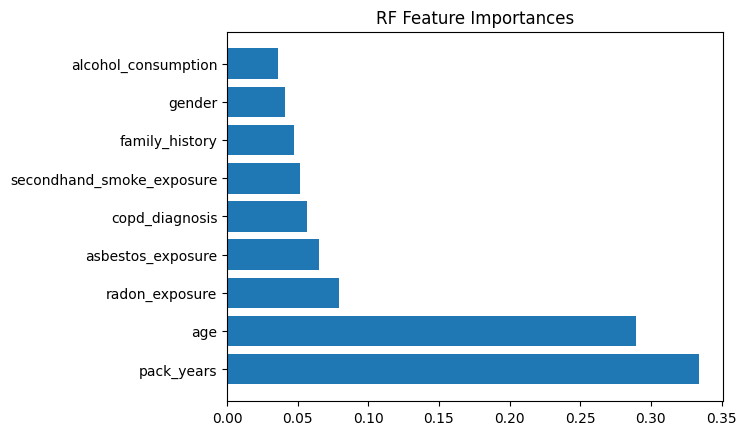

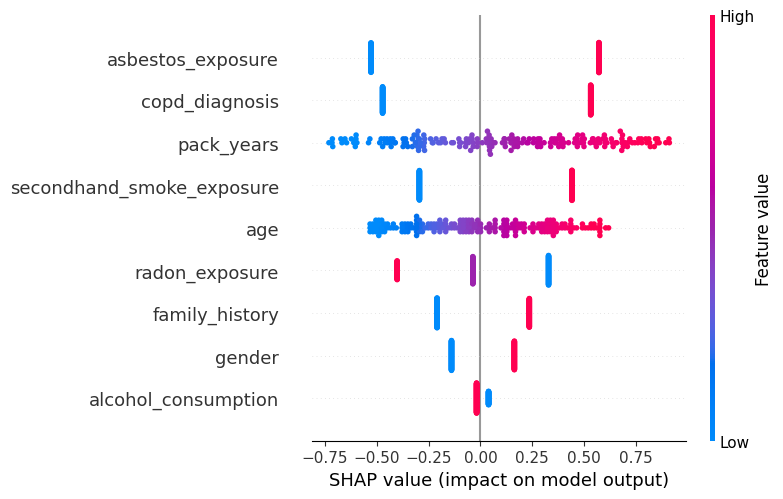

/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

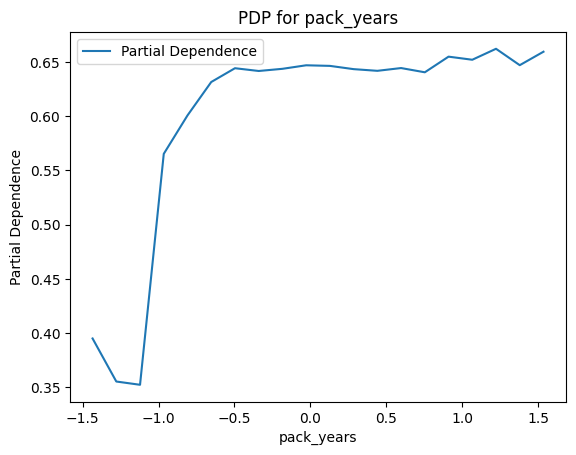

In [42]:
# Part 5: Explainable AI (XAI)
rf = ml_models['Random Forest']
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values('Importance', ascending=False)
print("\nRandom Forest Feature Importances:\n", feature_importance_df)
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('RF Feature Importances')
plt.show()

lr = ml_models['Logistic Regression']
explainer = shap.Explainer(lr, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

lime_explainer = lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=['No', 'Yes'], mode='classification')
exp = lime_explainer.explain_instance(X_test.iloc[0], rf.predict_proba)
exp.show_in_notebook()

pdp_results = partial_dependence(rf, X=X_test, features=['pack_years'], grid_resolution=20)
pdp_grid_values = pdp_results['grid_values'][0]  # Grid of feature values
pdp_average = pdp_results['average'][0]          # Average partial dependence
plt.plot(pdp_grid_values, pdp_average, label='Partial Dependence')
plt.xlabel('pack_years')
plt.ylabel('Partial Dependence')
plt.title('PDP for pack_years')
plt.legend()
plt.show()

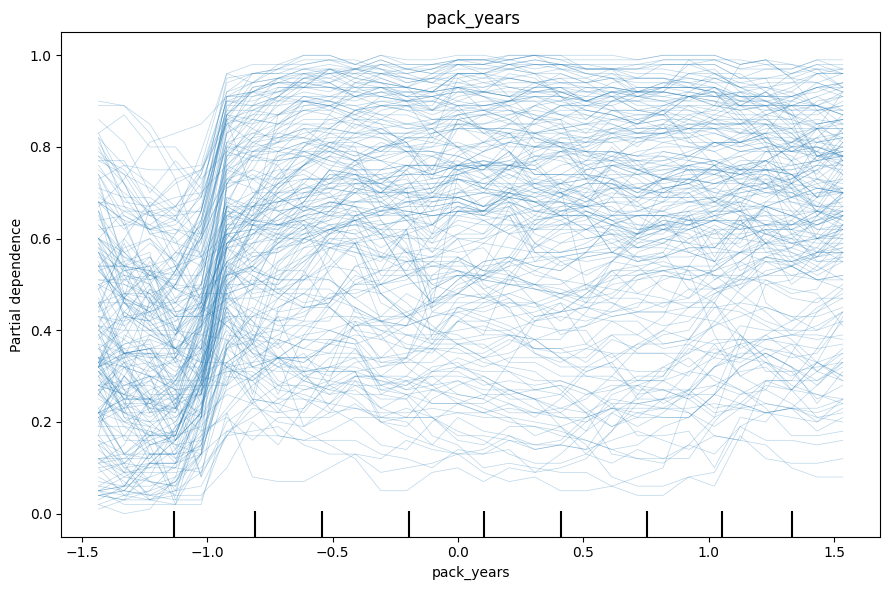

In [43]:
# sklearn approach: PDP + ICE together
from sklearn.inspection import PartialDependenceDisplay

features = ['pack_years']

fig, ax = plt.subplots(figsize=(9, 6))
# kind='both' plots both the averaged PDP and the individual ICE curves
PartialDependenceDisplay.from_estimator(
    rf,                # fitted RandomForest from your script
    X=X_test,          # dataset to compute PDP/ICE on
    features=features,
    kind='individual',       # 'individual' => ICE only, 'average' => PDP only, 'both' => both
    subsample=200,     # sample size for ICE (set None to use all rows)
    grid_resolution=30,
    n_jobs=1,
    ax=ax
)
ax.set_title(' pack_years')
plt.tight_layout()
plt.show()

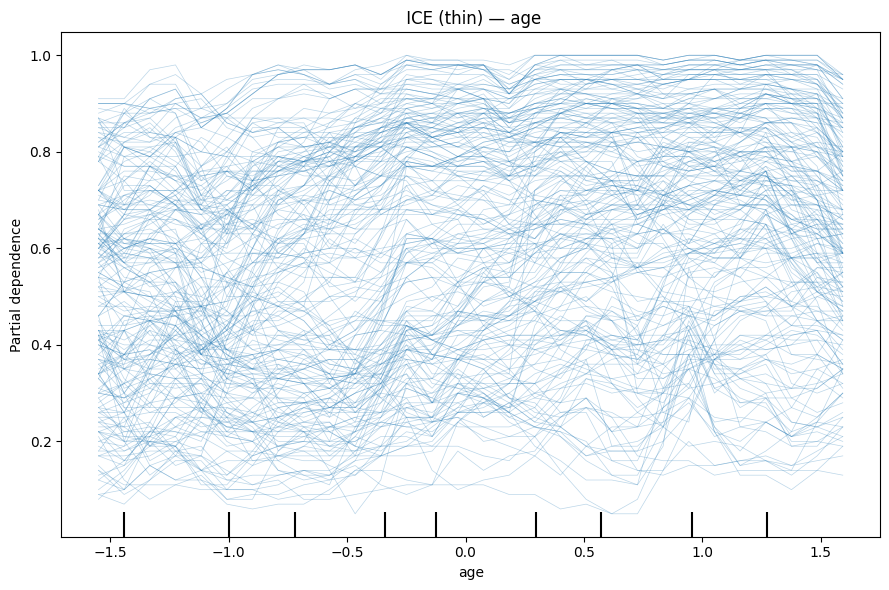

In [44]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features = ['age']   # New feature

fig, ax = plt.subplots(figsize=(9, 6))
PartialDependenceDisplay.from_estimator(
    rf,                # fitted RandomForest from your script
    X=X_test,          # dataset to compute PDP/ICE on
    features=features,
    kind='individual',       # show both PDP and ICE
    subsample=200,     # sample size for ICE
    grid_resolution=30,
    n_jobs=1,
    ax=ax
)
ax.set_title(' ICE (thin) — age')
plt.tight_layout()
plt.show()

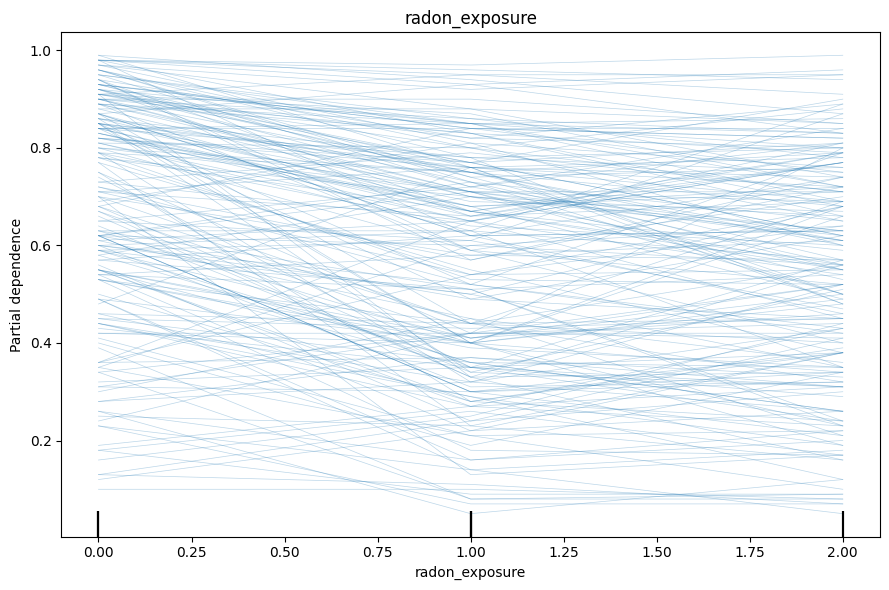

In [45]:
# sklearn approach: PDP + ICE together
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features = ['radon_exposure']   # changed feature

fig, ax = plt.subplots(figsize=(9, 6))
PartialDependenceDisplay.from_estimator(
    rf,                # fitted RandomForest
    X=X_test,          # dataset to compute PDP/ICE on
    features=features,
    kind='individual',       # PDP + ICE
    subsample=200,     # sample for ICE (or None to use all rows)
    grid_resolution=30,
    n_jobs=1,
    ax=ax
)
ax.set_title('radon_exposure')
plt.tight_layout()
plt.show()

In [46]:
# Part 6: Comparative Analysis
print("\nML Results:\n", ml_results_df)
dl_results = {'MLP': {'Accuracy': mlp_acc, 'F1': mlp_f1}, '1D CNN': {'Accuracy': cnn_acc, 'F1': cnn_f1}, 'LSTM': {'Accuracy': lstm_acc, 'F1': lstm_f1}}
dl_results_df = pd.DataFrame(dl_results).T
print("\nDL Results:\n", dl_results_df)


ML Results:
                      Accuracy  Precision    Recall        F1   ROC-AUC
Logistic Regression     0.670   0.772358  0.714286  0.742188  0.721805
Decision Tree           0.630   0.747899  0.669173  0.706349  0.610706
Random Forest           0.665   0.766129  0.714286  0.739300  0.745483
SVM                     0.665   0.794643  0.669173  0.726531  0.727640
KNN                     0.605   0.728814  0.646617  0.685259  0.656941
Gradient Boosting       0.720   0.818182  0.744361  0.779528  0.773763
XGBoost                 0.715   0.792308  0.774436  0.783270  0.732465

DL Results:
         Accuracy        F1
MLP        0.675  0.736842
1D CNN     0.650  0.687500
LSTM       0.675  0.752852


Report

Introduction

Lung cancer is one of the leading causes of cancer-related deaths worldwide.

Early prediction of lung cancer risk using patient lifestyle and medical data can improve prevention and treatment outcomes.

This project applies Machine Learning (ML) and Deep Learning (DL) models on the Kaggle Lung Cancer Risk Dataset to classify patient risk.

Explainable AI (XAI) techniques are integrated to ensure interpretability of predictions, which is critical in medical decision-making.

📌 Conclusion

Gradient Boosting and XGBoost achieved the best predictive performance among ML models.

Deep Learning models like LSTM and MLP performed reasonably but were limited by the small dataset size.

Random Forest with SHAP explanations provides a strong balance between accuracy and interpretability.

Key predictors such as smoking history (pack years) and age align with established medical knowledge.

For real-world use, interpretable ML models are recommended over black-box DL models unless larger datasets are available.

📌 Evaluation / Experiment Summary

Dataset: 1,000 rows (subset of the Kaggle dataset).

Preprocessing: Missing value imputation, encoding categorical variables, feature scaling, and SMOTE for class balance.

ML Models Tested: Logistic Regression, Decision Tree, Random Forest, SVM, KNN, Gradient Boosting, XGBoost.

DL Models Tested: MLP, 1D CNN, LSTM.

Evaluation Metrics: Accuracy, Precision, Recall, F1-score, ROC-AUC, Confusion Matrix.

XAI Techniques: Feature Importance, SHAP, LIME, PDP.

Findings: Gradient Boosting (best accuracy) and LSTM (best among DL) highlighted. Random Forest chosen for interpretability with SHAP/LIME insights.